 # generate a movie

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from dask import compute, delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *

In [4]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(5)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [7]:
client

Client Scheduler: tcp://10.135.39.89:44918 Dashboard: http://10.135.39.89:45498/status,Cluster Workers: 4 Cores: 32 Memory: 160.00 GB


---

## load grid and data

In [8]:
grd = load_grd()
#ds = load_datanc('Eta', suff='_t000001*.nc')
ds = load_data('Eta')
ds = xr.merge([grd,ds])
print(ds)
print('\n data size (all faces): %.1f GB' %(ds['Eta'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].isel(face=1).nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 67)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    Z        (k) float32 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    dyG      (face, j, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    YG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    Zu  

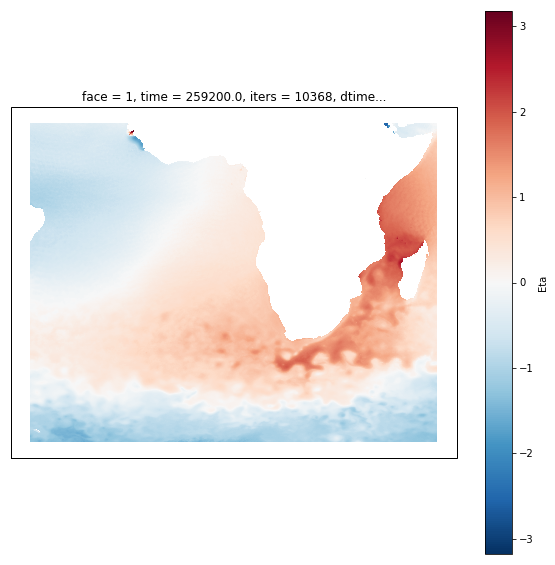

In [9]:
# plot one figure to check lon/lat treatment
import cartopy.crs as ccrs
eta = ds['Eta'].isel(face=1, time=0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
eta.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree())
#

---

# make movie

In [10]:
face = 1
vmin, vmax = -2., 2.

#delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

lds = ds.isel(face=face)

def process(ds, i, overwrite=True):
    
    # !! passing the variable ds['Eta'] does not work
    eta = ds['Eta']

    #time = pd.to_datetime(str(eta['time'].values))
    time = eta['time'].values/86400.
    figname = figdir+'mit_eta_f%d_t%05d' %(face, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = 'eta %.2f' %time
        plot_scalar(eta, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                    offline=True, coast_resolution=None, figsize=(15,10))
        #            offline=True, coast_resolution=None, figsize=(15,10))
        #'50m'
        #
        m = float(eta.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
#I = range(100)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

Figures directory: /home/mp/pontea/scratch/figs/


In [11]:
%time results = compute(*values, get=client.get)

CPU times: user 15.1 s, sys: 1.07 s, total: 16.2 s
Wall time: 5min 16s


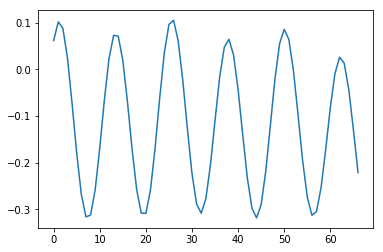

In [13]:
plt.plot(np.array(results))

---

# info, shutdown

In [ ]:
cluster.scheduler.close()

In [ ]:
client.restart()